## Patterns

### Class Complexity


We've seen that using object orientation can produce quite complex class structures, with classes owning each other, instantiating each other,
and inheriting from each other.

There are lots of different ways to design things, and decisions to make.

> - To reuse functionality: should I use inheritance, or add class variable which is delegated to? ("is a" vs "has a")
> - How much flexibility should I allow in this class's inner workings?
> - Should I split this related functionality into multiple classes or keep it in one?


### Design Patterns


Programmers have noticed that there are certain ways of arranging classes that work better than others.

These are called "design patterns".

They were first collected on one of the [world's first Wikis](http://c2.com/cgi/wiki?WelcomeVisitors), 
as the [Portland Pattern Repository](http://c2.com/cgi-bin/wiki?PatternIndex).


### Reading a pattern


A description of a pattern in a book such as the [Gang Of Four](https://www.worldcat.org/title/design-patterns-elements-of-reusable-object-oriented-software/oclc/31171684)
book ([UCL Library](https://ucl-new-primo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=UCL_LMS_DS21146030410004761&context=L&vid=UCL_VU2&search_scope=CSCOP_UCL&tab=local&lang=en_US)) usually includes:

* **Intent** - what's the purpose
* **Motivation** - why you want to use it
* **Applicability** - when do you want to use it
* **Structure** - what does it look like (e.g., UML diagram)
* **Participants** - What are the different classes in it
* **Collaborations** - how they work together
* **Consequences** - What are the results and trade-offs
* **Implementation** - How is it implemented
* **Sample Code** - In practice.


### Introducing Some Patterns


There are lots and lots of design patterns, and it's a great literature to get into to
read about design questions in programming and learn from other people's experience.

We'll just show a few in this session:

* [Strategy](#Strategy-Pattern)
* [Factory Method](#Factory-Method)
* [Builder](#Builder-Pattern)

Some explanations won't click for some people even though we've tried.
So if you're stuck on wrapping your head around a pattern,
check out another explanation from the [other resources section](#Other-resources)

### Supporting code

In [1]:
%matplotlib inline
from unittest.mock import Mock

from IPython.display import Image

def yuml(model):
    result=requests.get("http://yuml.me/diagram/boring/class/" + model)
    return Image(result.content)


## Strategy Pattern


Define a family of algorithms, encapsulate each one
(e.g. use a `has-a` relationship instead of inheritance), and make them interchangeable.
Strategy lets the algorithm vary independently, without requiring any class that uses it to change.


### Strategy pattern example: sunspots

In [2]:
import csv
from datetime import datetime
import math

import matplotlib.pyplot as plt
from numpy import linspace,log,sqrt, array
from numpy.fft import rfft,fft,fftfreq
from scipy.interpolate import UnivariateSpline
from scipy.signal import lombscargle
import requests

Consider the sequence of sunspot observations:


In [3]:
def load_sunspots():
    with open("SIDC-SUNSPOTS_A.csv") as header:
        data = csv.reader(header)

        next(data) # Skip header row
        # The numbers we want are in the 2nd column
        return [float(row[1]) for row in data]

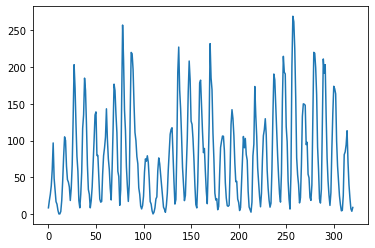

In [4]:
spots = load_sunspots()
plt.plot(spots)

### Sunspot cycle has periodicity

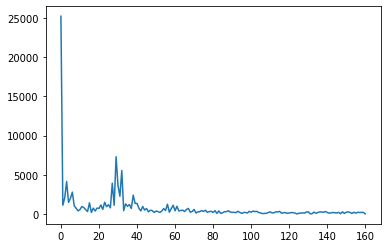

In [5]:
spectrum = rfft(spots)

plt.figure()
plt.plot(abs(spectrum))
plt.savefig('fixed.png')

### Years are not constant length

There's a potential problem with this analysis however:

* Years are not constant length
* Leap years exist
* But, the Fast Fourier Transform assumes evenly spaced intervals

We could:

* Ignore this problem, and assume the effect is small;
* Interpolate and resample to even times;
* Use a method which is robust to unevenly sampled series, such as [LSSA](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis);

We also want to find the period of the strongest periodic signal in the data, there are
various different methods we could use for this also, such as integrating the fourier series
by quadrature to find the mean frequency, or choosing the largest single value.

### Number of child-classes can increase quickly

We could implement a base class for our common code between the different approaches,
and define derived classes for each different algorithmic approach. However, this has drawbacks:

* The constructors for each derived class will need arguments for all the numerical method's control parameters,
such as the degree of spline for the interpolation method, the order of quadrature for integrators, and so on.
* Where we have multiple algorithmic choices to make (interpolator, periodogram, peak finder...) the number
of derived classes would explode: `class SunspotAnalyzerSplineFFTTrapeziumNearMode` is a bit unwieldy.
* The algorithmic choices are not then available for other projects (so we may have to reinvent the wheel next time)
* This design doesn't fit with a clean Ontology of "kinds of things": there's no Abstract Base for spectrogram generators...

### Apply the strategy pattern:

* We implement each algorithm for generating a spectrum as its own Strategy class.
* They all implement a common interface
* Arguments to strategy constructor specify parameters of algorithms, such as spline degree
* One strategy instance for each algorithm is passed to the constructor for the overall analysis

First, we'll define a helper class for our time series.

In [6]:
class Series:
    """Enhance NumPy N-d array with some helper functions for clarity"""
    def __init__(self, data):
        self.data = array(data)
        self.count = self.data.shape[0]
        self.start = self.data[0, 0]
        self.end = self.data[-1, 0]
        self.range = self.end - self.start
        self.step = self.range / self.count
        self.times = self.data[:, 0].copy()
        self.values = self.data[:, 1].copy()
        self.plot_data = [self.times, self.values]
        self.inverse_plot_data = [1.0 / self.times[20:], self.values[20:]]

Then, our analysis class which contains all methods *except* the numerical methods

In [7]:
class AnalyseSunspotData(object):
    def format_date(self, date):
        date_format="%Y-%m-%d"
        return datetime.strptime(date, date_format)

    def load_data(self):
        start_date_str = '1700-12-31'
        self.start_date = self.format_date(start_date_str)
        secs_per_year = (datetime(2014, 1, 1) - datetime(2013, 1, 1)
                                ).total_seconds()

        with open("SIDC-SUNSPOTS_A.csv") as header:
            data = csv.reader(header)

            next(data) # Skip header row
            self.series = Series([[
                    (self.format_date(row[0]) - self.start_date
                    ).total_seconds()/secs_per_year,
                    float(row[1])] for row in data])

    def __init__(self, frequency_strategy):
        self.load_data()
        self.frequency_strategy = frequency_strategy

    def frequency_data(self):
        return self.frequency_strategy.transform(self.series)

Here is our existing simple fourier method, implemented as a strategy

In [8]:
class FourierNearestFrequencyStrategy:
    def transform(self, series):
        transformed = fft(series.values)[0:series.count//2]
        frequencies = fftfreq(series.count, series.step)[0:series.count//2]
        return Series(list(zip(frequencies, abs(transformed)/series.count)))

A strategy based on interpolation to a spline

In [9]:
class FourierSplineFrequencyStrategy:
    def next_power_of_two(self, value):
        """Return the next power of 2 above value"""
        return 2**(1 + int(log(value) / log(2)))

    def transform(self, series):
        spline = UnivariateSpline(series.times, series.values)
        # Linspace will give us *evenly* spaced points in the series
        fft_count = self.next_power_of_two(series.count)
        points = linspace(series.start,series.end,fft_count)
        regular_xs = [spline(point) for point in points]
        transformed = fft(regular_xs)[0:fft_count//2]
        frequencies = fftfreq(fft_count,
                              series.range/fft_count)[0:fft_count//2]
        return Series(list(zip(frequencies, abs(transformed)/fft_count)))

A strategy using the Lomb-Scargle Periodogram

In [10]:
class LombFrequencyStrategy:
    def transform(self, series):
        frequencies = array(linspace(1.0 / series.range,
                                     0.5 / series.step,
                                     series.count))
        result = lombscargle(series.times,
                             series.values,
                             2.0 * math.pi * frequencies)
        return Series(list(zip(frequencies, sqrt(result / series.count))))

Define our concrete solutions with particular strategies,
now it's more straightforward to interchange which numerical method we want the object to use.

In [11]:
fourier_model = AnalyseSunspotData(FourierSplineFrequencyStrategy())
lomb_model = AnalyseSunspotData(LombFrequencyStrategy())
nearest_model = AnalyseSunspotData(FourierNearestFrequencyStrategy())

Use these new tools to compare solutions

In [12]:
comparison = fourier_model.frequency_data().inverse_plot_data + ['r']
comparison += lomb_model.frequency_data().inverse_plot_data + ['g']
comparison += nearest_model.frequency_data().inverse_plot_data + ['b']

In [13]:
deviation = 365 * (fourier_model.series.times-linspace(
    fourier_model.series.start,
    fourier_model.series.end,
    fourier_model.series.count))

(0.0, 16.0)

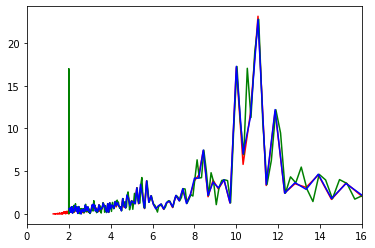

In [14]:
plt.plot(*comparison)
plt.xlim(0, 16)

### Results: Deviation of year length from average

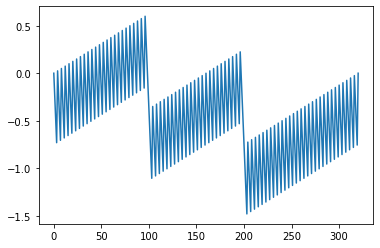

In [15]:
plt.plot(deviation)

## Factory Method


Here's what the Gang of Four Book says about Factory Method:

**Intent**:  Define an interface for creating an object, but let subclasses decide which class to instantiate.
Factory Method lets a class defer instantiation to subclasses.

**Applicability**: Use the Factory method pattern when:

* A class can't anticipate the class of objects it must create
* A class wants its subclasses to specify the objects it creates

### Factory UML
<!-- TODO: YUM doesn't seem to have output in HTML -->

In [16]:
yuml("[Product]^-[ConcreteProduct], "
     "[Creator| (v) FactoryMethod()]^-[ConcreteCreator| FactoryMethod()], "
     "[ConcreteCreator]-.->[ConcreteProduct]")

This is all very abstract, so let's get a clearer idea of what that means with an example.

### Initial Example

We have created code that can analyse imaging data from different types of instrument.
However we still want to be able to interact with the imaging data in the same way,
independent of how each instrument stores its data.

To do this we have created a `GenericImage` class which implements default methods for interacting
with imaging data.



In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors


# Create some mocked helper functions so example runs
ImageNormalize = Mock()
source_stretch = Mock()


class GenericImage:
    def __init__(self, data, header):
        """Read image and populate image metadata"""
        self.data = data
        ...

    def text_summary(self):
        """Outputs table summary table of image metadata"""
        return "\n".join(f"Observatory: {self.observatory}",
                         f"Instrument: {self.instrument}",
                         f"Detector: {self.detector}",
                         f"Observation Date:: {self.observation_date}",
                         f"Scale: {self.scale}",
                         )

    def plot(self):
        """Plot normalised and coloured image"""
        normalised_data = self._normalise()
        colour_data = self._get_colour_image(normalised_data)
        # plot the image data the image data
        colour_data.plot()
        plt.colorbar()
        plt.show()

    def _normalise(self):
        """Default normalisation for the instrument"""
        # image normaliser not shown here, but used as an example
        normaliser = ImageNormalize(stretch=source_stretch(self.meta,PowerStretch(0.01)),
                                    clip=False)
        return normaliser.normalise(self.data)

    def _get_colour_image(self, normalised_data):
        """Converts image data into coloured image based on colourmap for the instrument"""
        normalised_data.plot_settings['cmap'] = plt.get_cmap('inferno')
        normalised_data.plot_settings['norm'] = colors.Normalize(0, normalised_data.max())
        return normalised_data

### Implemented classes

Here are four example child classes that have implemented their own internal methods for normalising
the image data and creating a coloured image. We can use these in exactly the same way as our
GenericImage classes because of polymorphism, we're just using the same methods that exist in
the parent class.


In [18]:
class AIAImage(GenericImage):
    """Atmospheric Imaging Assembly image reader"""
    def __init__(self, data, header):
        super().__init__(data, header)
        self.instrument = "AIA"
        ...

    def _normalise(self):
        # image normaliser not shown here, but used as an example
        normaliser = ImageNormalize(stretch=source_stretch(self.meta,0.01), clip=False)
        return normaliser.normalise(self.data)

    def _get_colour_image(self, normalised_data):
        normalised_data.plot_settings['cmap'] = plt.get_cmap('Greys_r')
        normalised_data.plot_settings['norm'] = colors.LogNorm(100, normalised_data.max())
        return normalised_data


class HIImage(GenericImage):
        """STEREO-SECCHI Heliospheric Imager (HI) reader"""
        def __init__(self, data, header):
            super().__init__(data, header)
            self.instrument = "HI"
            ...

        def _normalise(self):
            # image normaliser not shown here, but used as an example
            normaliser = ImageNormalize(stretch=source_stretch(self.meta,PowerStretch(0.25)),
                                        clip=False)
            return normaliser.normalise(self.data)

        def _get_colour_image(self, normalised_data):
            normalised_data.plot_settings['cmap'] = 'stereocor{det!s}'.format(det=self.detector[-1])
            normalised_data.plot_settings['norm'] = colors.Normalize(0, normalised_data.max())
            return normalised_data


Let's imagine that we've done the hard work and implemented another 10 different image sources.
Whenever we load an image we want to use the correct image class, falling back to the GenericImage
if we can't fine a match from our known entities.

A naive implementation of this would to have an `if else` block where we use the image metadata
to determine what the right image class is.


In [19]:
class ImageFactory:
    def read_image(self, path):
        """Reads image from path, using the appropriate image class"""
        # reads in filepath and returns image data and metadata
        data, header = Image.read(path)


        if str(header.get('detector', '')).startswith('HI'):
            return HIImage(data, header)
        elif str(header.get('instrume', '')).startswith('AIA'):
            return AIAImage(data, header)
        # ...this would continue for all 10 other image sources
        # after we've gone through all possible matches to known data types
        else:
            return GenericImage(data, header)



We can read in several images without explicitly deciding the child class within our own analysis code
```python
image_factory = ImageFactory()

image_1 = image_factory.read_image("testing/reading_AIA_AIA_193.jp2")
image_1.text_summary()
image_1.plot()

image_2 = image_factory.read_image("testing/hi_20110910_114721_s7h2A.fts")
image_2.plot()
```

This is the *factory method* pattern:
a common design solution to the need to defer the construction of child-objects to a derived class.
With polymorphism we can use any image object returned form the `read_image` function without
knowing the underlying image source.

Having this in a class can allow for more complex logic to determine which child
class should be returned from the factory method, including leveraging the statefullness of the
class to help with the logic.

<!--
    We could also expand on this and show how to automatically register children classes,
    though maybe that's a bit over the top just to showcase the pattern.
-->

## Builder Pattern

**Intent**: Separate the steps for constructing a complex object from its final representation.

In [20]:
yuml("[Director|Construct()]<>->[Builder| (a) BuildPart()],"+
     " [Builder]^-[ConcreteBuilder| BuildPart();GetResult() ],"+
     "[ConcreteBuilder]-.->[Product]")

### Builder example

Imagine that we have a large model with many parameters that we want to run.

There's a lot more to defining a model than just adding agents of different kinds:
we need to define boundary conditions, specify wind speed or light conditions.

We could define all of this for an imagined advanced Model with a
very very long constructor, with lots of optional arguments:

In [21]:
class Model:
    def __init__(self, xsize, ysize,
                 agent_count, wind_speed,
                 agent_sight_range, eagle_start_location):
        pass

#### Builder preferred to complex constructor

However, long constructors easily become very complicated.
Instead, it can be cleaner to define a Builder for models.
A builder is like a deferred factory:
each step of the construction process is implemented as an individual method call,
and the completed object is returned when the model is ready.


In [22]:
Model = Mock() # Create a temporary mock so the example works!

In [23]:
class ModelBuilder:
    def start_model(self):
        self.model = Model()
        self.model.xlim = None
        self.model.ylim = None
        
    def set_bounds(self, xlim, ylim):
        self.model.xlim = xlim
        self.model.ylim = ylim
    
    def add_agent(self, xpos, ypos):
        pass # Implementation here
    
    def finish(self):
        self.validate()
        return self.model
    
    def validate(self):
        assert(self.model.xlim is not None)
        # Check that the all the
        # parameters that need to be set
        # have indeed been set.


Inheritance of an Abstract Builder for multiple concrete builders could be used
where there might be multiple ways to build models with the same set of calls to the builder:
for example a version of the model builder yielding models which can be executed
in parallel on a remote cluster.


### Using a builder

In [24]:
builder = ModelBuilder()
builder.start_model()

builder.set_bounds(500, 500)
builder.add_agent(40, 40)
builder.add_agent(400, 100)

model = builder.finish()
model.simulate()

<Mock name='mock().simulate()' id='4973215264'>

### Avoid staged construction without a builder.


We could, of course, just add all the building methods to the model itself,
rather than having the model be yielded from a separate builder.

This is an antipattern that is often seen: a class whose `__init__` constructor alone is insufficient
for it to be ready to use. A series of methods must be called, in the right order,
in order for it to be ready to use.

This results in very fragile code: its hard to keep track of whether an object instance is "ready" or not.
Use the builder pattern to keep deferred construction in control.

We might ask why we couldn't just use a validator in all of the methods that must follow the deferred constructors;
to check they have been called.
But we'd need to put these in *every* method of the class,
whereas with a builder, we can validate only in the `finish` method.


### Other resources

There are a lot of design patterns and one explanation might not work well for all people so here are some extra
sources of information about them. Spending some time to understand them can pay off in the future so you don't
reinvent the wheel!

- [Course on design patterns](https://www.linkedin.com/learning/python-design-patterns-2015/welcome)
  and [Advanced design patterns](https://www.linkedin.com/learning/python-advanced-design-patterns/welcome)
  with Python at [linkedin learning](https://www.ucl.ac.uk/isd/linkedin-learning).
- [A collection of design patterns and idioms in Python](https://github.com/faif/python-patterns).
- [Head First Design Patterns](http://www.worldcat.org/title/head-first-design-patterns/oclc/893944765)
  (Available [online at UCL](https://ucl-new-primo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=UCL_LMS_DS51233633660004761&context=L&vid=UCL_VU2&search_scope=CSCOP_UCL&tab=local&lang=en_US)
  or [O'Reilly](https://learning.oreilly.com/library/view/head-first-design/0596007124/?sso_link=yes&sso_link_from=university-college-london)
  : sign in using your UCL email) - based on Java (with [online course at linkedin learning](https://www.linkedin.com/learning/programming-foundations-design-patterns-2/don-t-reinvent-the-wheel)).
- [Design Pattern for Dummies](http://www.worldcat.org/title/design-patterns-for-dummies/oclc/69537420&referer=brief_results)
  (Available on [O'Reilly](https://learning.oreilly.com/library/view/design-patterns-for/9780471798545/?sso_link=yes&sso_link_from=university-college-london)
  : sign in using your UCL email).
